In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [6]:
# import data
brca_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
og_rna_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
rnaseq_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/TCGA_BRCA_ExprDeconvolution_training.csv',  index_col=0)
rnaseq_df.head


<bound method NDFrame.head of                                  NOC2L  PLEKHN1     HES4     ISG15       AGRN  \
TCGA-3C-AAAU-01A-11R-A41B-07  7014.780  735.864  218.180   792.460  14311.184   
TCGA-3C-AALI-01A-11R-A41B-07  1869.260  149.212  333.760   792.168   2853.296   
TCGA-3C-AALK-01A-11R-A41B-07  3722.696  858.212  686.360   849.168  13086.220   
TCGA-A1-A0SE-01A-11R-A084-07  3380.752  150.696   68.580   320.296  11528.724   
TCGA-A1-A0SF-01A-11R-A144-07  4120.980  343.252   54.152   301.516  10883.852   
...                                ...      ...      ...       ...        ...   
TCGA-E2-A2P5-01A-11R-A19W-07  4423.836  321.508  197.328   968.792   8066.548   
TCGA-AC-A2FE-01A-11R-A19W-07  1820.324  114.816  127.468  1760.508   5137.288   
TCGA-EW-A3E8-01B-11R-A24H-07  5453.568  772.756  611.776  5520.484  13198.048   
TCGA-D8-A3Z5-01A-41R-A24H-07  5669.208  477.080  794.992   692.900  18635.616   
TCGA-A8-A08C-01A-11R-A00Z-07  3901.620  342.412  120.664   697.832  10200.500  

In [17]:
import pandas as pd

def match_case_ids(df1, df2):
    """
    Modify df2's index to match df1's Case ID format and compare them
    
    Parameters:
    df1: First dataframe with Case ID column
    df2: Second dataframe with TCGA sample IDs as index
    
    Returns:
    tuple: (modified df2, boolean mask of matching indices)
    """
    # Extract Case IDs from df1
    case_ids_df1 = df1['Case ID'].unique()
    
    # Convert df2's index to match Case ID format
    # Current format: TCGA-XX-XXXX-01X-XXR-XXXX-XX
    # Target format: TCGA-XX-XXXX
    new_case_ids = df2.index.str.extract('(TCGA-\w\w-\w\w\w\w)')[0]
    
    # Create a copy of df2
    df2_modified = df2.copy()
    
    # Reset the index to default numeric index and add Case ID as a column
    df2_modified = df2_modified.reset_index(drop=True)
    df2_modified.insert(0, 'Case ID', new_case_ids)
    
    # Check which case IDs match
    matching_cases = df2_modified['Case ID'].isin(case_ids_df1)
    
    # Print summary statistics
    print(f"Total cases in df1: {len(case_ids_df1)}")
    print(f"Total cases in df2: {len(df2_modified)}")
    print(f"Number of matching cases: {matching_cases.sum()}")
    print(f"Number of non-matching cases: {(~matching_cases).sum()}")
    
    return df2_modified, matching_cases

# Example usage:
# df2_modified, matches = match_case_ids(df1, df2)

# To see non-matching cases:
# non_matching_df2 = df2_modified[~matches]
# non_matching_df1 = df1[~df1['Case ID'].isin(df2_modified['Case ID'])]

<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_65221/2366072738.py:20: SyntaxWarning: invalid escape sequence '\w'
  new_case_ids = df2.index.str.extract('(TCGA-\w\w-\w\w\w\w)')[0]


In [18]:
og_rna_df_z = og_rna_df.copy()
rnaseq_df_z = rnaseq_df.copy()

df2_modified, matches = match_case_ids(og_rna_df_z, rnaseq_df_z)


Total cases in df1: 1095
Total cases in df2: 622
Number of matching cases: 622
Number of non-matching cases: 0


In [19]:
 # Rename the index to 'Case ID'
df2_modified.head()


,Case ID,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
0,TCGA-3C-AAAU,7014.780,735.864,218.180,792.460,14311.184,534.604,1165.740,1706.192,8600.396,...,4135.352,899.236,4764.276,4872.996,351.604,1424.376,4952.292,3316.272,23.848,5001.188
1,TCGA-3C-AALI,1869.260,149.212,333.760,792.168,2853.296,46.708,265.304,195.200,2310.480,...,5018.776,283.844,2170.252,1038.396,151.324,590.240,898.484,1542.276,79.496,2060.468
2,TCGA-3C-AALK,3722.696,858.212,686.360,849.168,13086.220,713.896,914.300,639.528,4446.440,...,7463.896,307.776,1845.476,978.900,228.900,442.792,1172.336,1388.096,132.076,3006.012
3,TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
4,TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544


In [20]:

rnaseq_df = df2_modified

In [21]:

# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)


Number of common samples: 571
rnaseq_df_common: (571, 9854)
brca_df_common: (571, 41)


In [22]:
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

rnaseq_df_common.set_index('Case ID', inplace=True)
rnaseq_df_common.head()

Duplicate Case IDs in rnaseq_df: 0

After removing duplicates:
rnaseq_df_common: (571, 9854)
brca_df_common: (571, 41)

Samples match: True
Number of samples in each: 571 571


,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,1069.940,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,1601.472,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544
TCGA-A1-A0SG,5420.084,408.852,261.284,2210.040,21232.732,257.616,723.684,173.744,5229.796,1537.608,...,6133.100,364.436,2076.056,2683.584,296.604,307.684,1970.432,1689.644,58.556,3738.876
TCGA-A1-A0SH,1008.980,80.276,25.388,97.044,3012.744,32.364,141.700,39.812,1739.056,336.224,...,5002.996,250.480,1451.992,789.916,113.436,100.132,1222.908,607.572,51.804,1527.064
TCGA-A1-A0SJ,4287.344,310.600,147.812,1002.000,14822.544,332.180,347.532,1629.596,4692.144,793.660,...,4865.652,259.364,2957.256,1766.404,464.536,315.996,1303.680,1255.980,363.208,2787.520


In [23]:

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()

# Verify indices match exactly
indices_match = (rnaseq_df_common.index == brca_df_common.index).all()
print("\nIndices match exactly:", indices_match)



Indices match exactly: True


In [24]:
print(brca_df_common.shape)
brca_df_common.head()

(571, 41)


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC,HRD_status_base,HRD_adjust,soft_prob,Confidence
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,6,6,1,13,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP ambiguous,0.13875,0.032295
TCGA-A1-A0SF,7,11,8,26,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP ambiguous,0.48000,0.310026
TCGA-A1-A0SG,3,2,4,9,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP,0.00000,0.014774
TCGA-A1-A0SH,8,13,13,34,somatic.nonsense,germline.null_or_pathogenic,0.0,0,0,0,...,0,0,0,YES,LumA,0,HR,HRD ambiguous,0.52000,0.689974
TCGA-A1-A0SJ,9,17,3,29,0,0,0.0,0,0,0,...,0,0,0,0,LumA,0,HR,HRP ambiguous,0.49875,0.450166


In [25]:
print(rnaseq_df_common.shape)
rnaseq_df_common.head()

(571, 9853)


,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,1069.940,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,1601.472,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544
TCGA-A1-A0SG,5420.084,408.852,261.284,2210.040,21232.732,257.616,723.684,173.744,5229.796,1537.608,...,6133.100,364.436,2076.056,2683.584,296.604,307.684,1970.432,1689.644,58.556,3738.876
TCGA-A1-A0SH,1008.980,80.276,25.388,97.044,3012.744,32.364,141.700,39.812,1739.056,336.224,...,5002.996,250.480,1451.992,789.916,113.436,100.132,1222.908,607.572,51.804,1527.064
TCGA-A1-A0SJ,4287.344,310.600,147.812,1002.000,14822.544,332.180,347.532,1629.596,4692.144,793.660,...,4865.652,259.364,2957.256,1766.404,464.536,315.996,1303.680,1255.980,363.208,2787.520


In [26]:
# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/deseq_bottom_2_percent.tsv', sep = '\t', index_col=0)



deseq_results.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000163975.12|MELTF|protein_coding,4.223192,2.197306,0.122265,17.971715,3.245282e-72,6.764141e-68
ENSG00000115163.15|CENPA|protein_coding,4.405742,1.489792,0.087457,17.034565,4.551128e-65,4.742959e-61
ENSG00000107937.19|GTPBP4|protein_coding,13.539092,0.820738,0.048266,17.004536,7.600421e-65,5.280519e-61
ENSG00000136943.11|CTSV|protein_coding,2.170985,1.952020,0.120999,16.132475,1.508526e-58,7.860554e-55
ENSG00000140545.15|MFGE8|protein_coding,31.920965,1.701760,0.106421,15.990768,1.481928e-57,6.177567e-54


In [27]:

# Filter columns in rna_seq_df based on deseq_results row indices
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index]]
print(deseq_filtered_rna_seq_df.shape)
deseq_filtered_rna_seq_df.head()

(571, 0)


""
Case ID
TCGA-A1-A0SE
TCGA-A1-A0SF
TCGA-A1-A0SG
TCGA-A1-A0SH
TCGA-A1-A0SJ


In [32]:
rnaseq_df_common.head()
rnaseq_df_top_genes = rnaseq_df_common

In [33]:
rnaseq_df_top_genes.head()

,NOC2L,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,SDF4,B3GALT6,...,COL6A2,SPATC1L,LSS,MCM3AP,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SE,3380.752,150.696,68.580,320.296,11528.724,186.432,377.524,571.384,4192.564,1069.940,...,4781.904,247.084,1740.580,2071.824,333.424,193.120,1619.016,1305.312,165.900,3120.104
TCGA-A1-A0SF,4120.980,343.252,54.152,301.516,10883.852,146.044,541.796,523.308,5013.884,1601.472,...,4257.988,576.748,1591.024,1266.920,211.308,235.060,1601.952,1150.512,202.532,2874.544
TCGA-A1-A0SG,5420.084,408.852,261.284,2210.040,21232.732,257.616,723.684,173.744,5229.796,1537.608,...,6133.100,364.436,2076.056,2683.584,296.604,307.684,1970.432,1689.644,58.556,3738.876
TCGA-A1-A0SH,1008.980,80.276,25.388,97.044,3012.744,32.364,141.700,39.812,1739.056,336.224,...,5002.996,250.480,1451.992,789.916,113.436,100.132,1222.908,607.572,51.804,1527.064
TCGA-A1-A0SJ,4287.344,310.600,147.812,1002.000,14822.544,332.180,347.532,1629.596,4692.144,793.660,...,4865.652,259.364,2957.256,1766.404,464.536,315.996,1303.680,1255.980,363.208,2787.520


In [34]:
#files to use for training/testing

#top 2% of expressed protein coding genes
rnaseq_df_top_genes.head()
print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
brca_df_common.head()
print(brca_df_common.shape)


(571, 9853)
(571, 0)
(571, 41)


In [35]:
brca_df_common['Confidence'].value_counts()

Confidence
0.014774    22
0.012128    17
0.005486    17
0.026597    17
0.006693    16
            ..
0.997975     1
0.999991     1
0.999989     1
0.942676     1
0.999975     1
Name: count, Length: 88, dtype: int64

In [36]:
brca_df_common['HRD_status_base'].value_counts()

HRD_status_base
HR     436
HRD    135
Name: count, dtype: int64

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score, f1_score, recall_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


Training models on top 2% expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

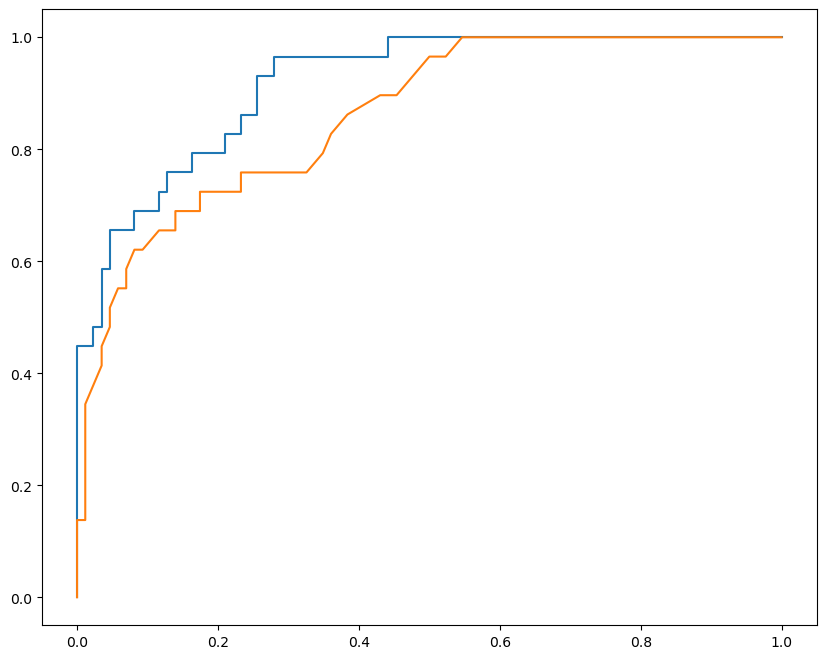

In [38]:
# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results


# Main execution
def main():
    # For top 2% expressed genes
    print("Training models on top 2% expressed genes:")
    
    # Classification
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    # Neural Network
    nn_model_top = create_nn_classifier(rnaseq_df_top_genes.shape[1])
    history_top = nn_model_top.fit(
        X_train_top, y_train_top,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    # For differentially expressed genes
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df,brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    # Print results
    print("\nResults for top 2% expressed genes:")
    for model_name, metrics in results_top.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# Run regression models
def run_regression():
    print("\nTraining regression models for Confidence prediction:")
    
    # For top 2% expressed genes
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, md['Confidence'], task='regression'
    )
    
    results_top_reg = train_evaluate_regression_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    print("\nRegression Results for top 2% expressed genes:")
    for model_name, metrics in results_top_reg.items():
        print(f"\n{model_name}:")
        print(f"MSE: {metrics['MSE']:.6f}")
        print(f"R2: {metrics['R2']:.3f}")


main()
run_regression()

Training models on top 2% expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


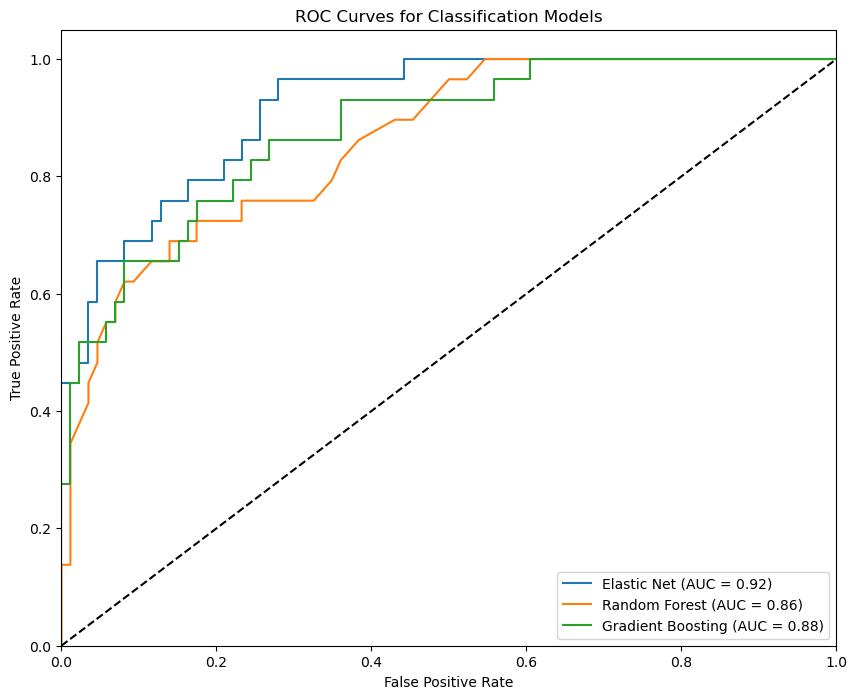


Training models on differentially expressed genes:


ValueError: at least one array or dtype is required

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

# Main execution
def main():
    # For top 2% expressed genes
    print("Training models on top 2% expressed genes:")
    
    # Classification
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    # For differentially expressed genes
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df, brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    # Print results
    print("\nResults for top 2% expressed genes:")
    for model_name, metrics in results_top.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# Run regression models
def run_regression():
    print("\nTraining regression models for Confidence prediction:")
    
    # For top 2% expressed genes
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, brca_df_common['Confidence'], task='regression'
    )
    
    results_top_reg = train_evaluate_regression_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    print("\nRegression Results for top 2% expressed genes:")
    for model_name, metrics in results_top_reg.items():
        print(f"\n{model_name}:")
        print(f"MSE: {metrics['MSE']:.6f}")
        print(f"R2: {metrics['R2']:.3f}")

main()
run_regression()

Training models on expression deconvolution genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


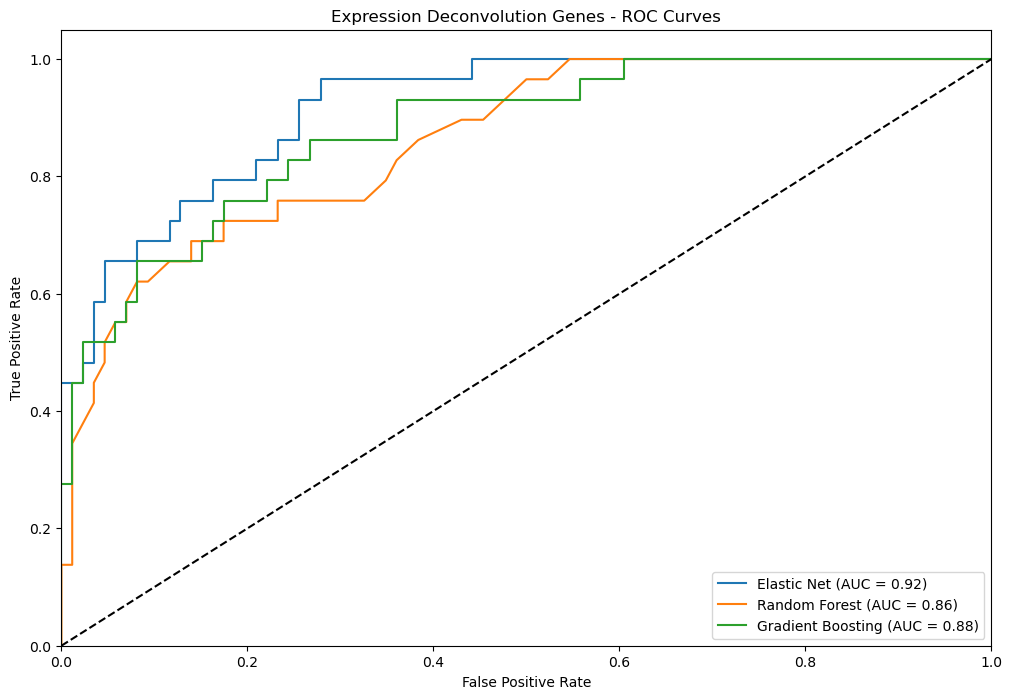

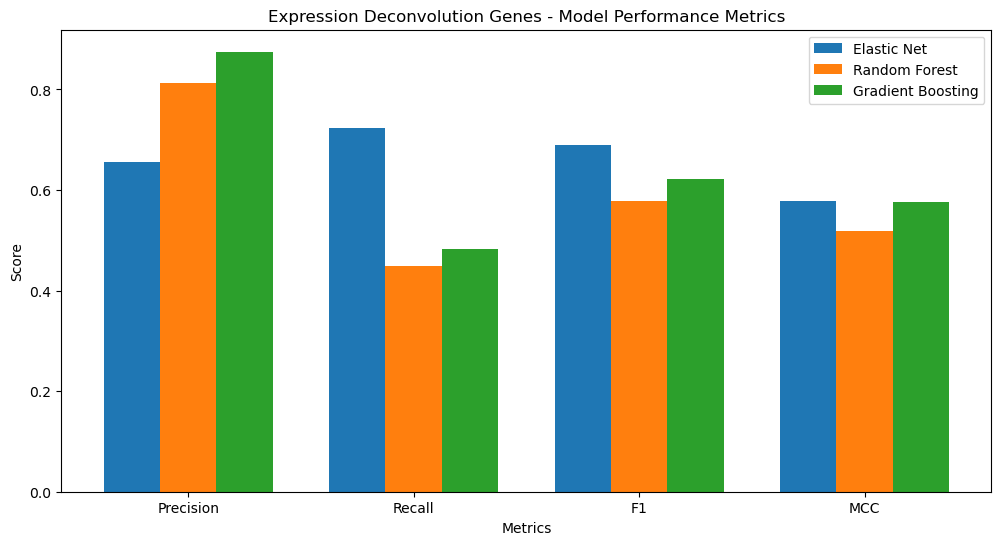

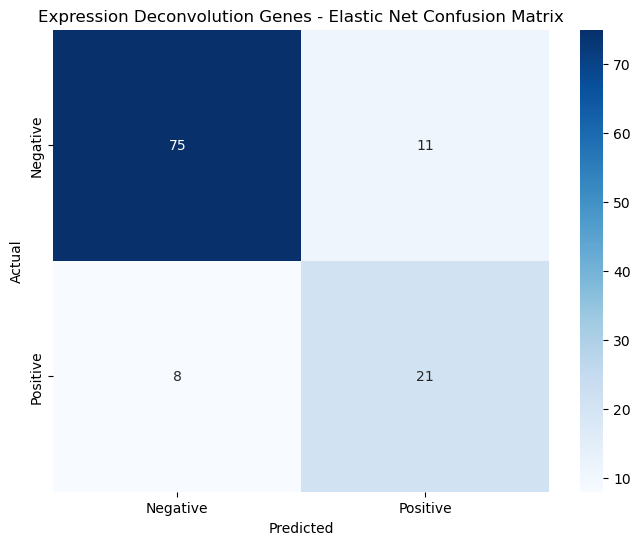

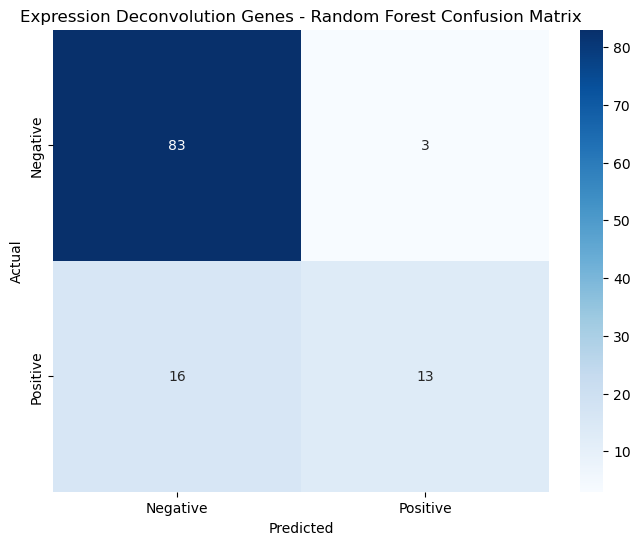

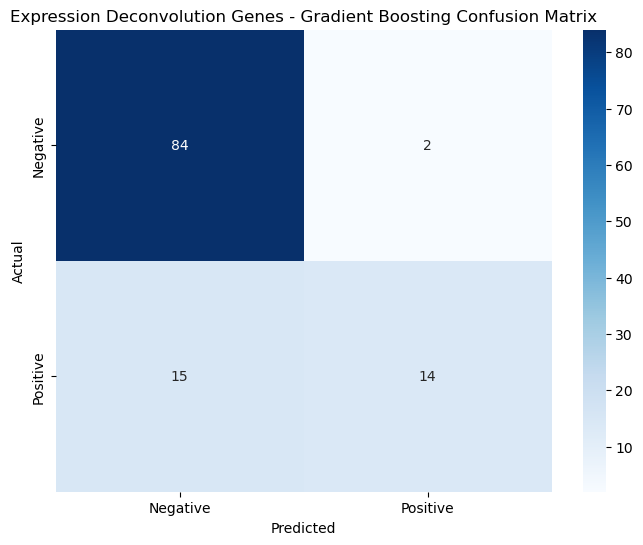


Results for Expression Deconvolution:

Elastic Net:
Precision: 0.656
Recall: 0.724
F1: 0.689
MCC: 0.578
AUC: 0.918

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        86
           1       0.66      0.72      0.69        29

    accuracy                           0.83       115
   macro avg       0.78      0.80      0.79       115
weighted avg       0.84      0.83      0.84       115


Random Forest:
Precision: 0.812
Recall: 0.448
F1: 0.578
MCC: 0.519
AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        86
           1       0.81      0.45      0.58        29

    accuracy                           0.83       115
   macro avg       0.83      0.71      0.74       115
weighted avg       0.83      0.83      0.82       115


Gradient Boosting:
Precision: 0.875
Recall: 0.483
F1: 0.622
MCC: 0.577
AUC: 0.879

Classification Repo

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report,
                           precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(X, y, task='classification'):
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'Classification Report': classification_report(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        metrics['ROC'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}
    
    return metrics

def plot_metrics(results, title_prefix=""):
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    for name, metrics in results.items():
        roc = metrics['ROC']
        plt.plot(roc['fpr'], roc['tpr'], 
                label=f'{name} (AUC = {roc["auc"]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

    # Plot other metrics as bar chart
    metrics_to_plot = ['Precision', 'Recall', 'F1', 'MCC']
    metrics_data = {
        name: [metrics[m] for m in metrics_to_plot] 
        for name, metrics in results.items()
    }
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.25
    
    for i, (model_name, values) in enumerate(metrics_data.items()):
        plt.bar(x + i*width, values, width, label=model_name)
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'{title_prefix} Model Performance Metrics')
    plt.xticks(x + width, metrics_to_plot)
    plt.legend()
    plt.show()

    # Plot confusion matrices
    for name, metrics in results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'{title_prefix} {name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate all metrics
        results[name] = calculate_metrics(y_test, y_pred, y_pred_proba)
    
    return results

def main():
    # For top 2% expressed genes
    print("Training models on expression deconvolution genes:")
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, brca_df_common['HRD_status_base']
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    plot_metrics(results_top, "Expression Deconvolution Genes -")
    
    
    # Print detailed results
    for dataset_name, results in [("Expression Deconvolution", results_top)]:
        print(f"\nResults for {dataset_name}:")
        for model_name, metrics in results.items():
            print(f"\n{model_name}:")
            print(f"Precision: {metrics['Precision']:.3f}")
            print(f"Recall: {metrics['Recall']:.3f}")
            print(f"F1: {metrics['F1']:.3f}")
            print(f"MCC: {metrics['MCC']:.3f}")
            print(f"AUC: {metrics['ROC']['auc']:.3f}")
            print("\nClassification Report:")
            print(metrics['Classification Report'])

if __name__ == "__main__":
    main()

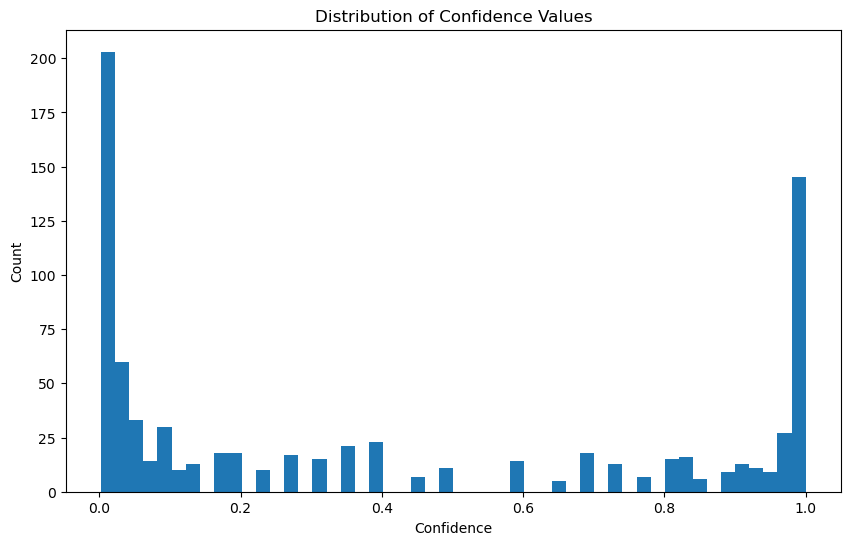


Preparing data...


IndexError: index -1 is out of bounds for axis 0 with size 0

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def identify_high_confidence_samples(confidence_values, threshold_percentile=10):
    """
    Identify high-confidence samples from both ends of the sigmoid distribution
    """
    lower_threshold = np.percentile(confidence_values, threshold_percentile)
    upper_threshold = np.percentile(confidence_values, 100-threshold_percentile)
    
    return (confidence_values <= lower_threshold) | (confidence_values >= upper_threshold)

def preprocess_data(X, confidence_values, threshold_percentile=10):
    """
    Preprocess data using only high confidence samples for training
    """
    # Make sure X and confidence_values have same index
    X = X.copy()
    confidence_values = confidence_values.copy()
    
    # Ensure indices match
    common_index = X.index.intersection(confidence_values.index)
    X = X.loc[common_index]
    confidence_values = confidence_values.loc[common_index]
    
    # Identify high confidence samples
    high_confidence_mask = identify_high_confidence_samples(confidence_values, threshold_percentile)
    
    # Split data into training (high confidence) and validation (remaining) sets
    X_high_conf = X[high_confidence_mask]
    y_high_conf = confidence_values[high_confidence_mask]
    X_ambiguous = X[~high_confidence_mask]
    y_ambiguous = confidence_values[~high_confidence_mask]
    
    # Further split high confidence data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_high_conf, y_high_conf, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_ambiguous_scaled = scaler.transform(X_ambiguous)
    
    # Convert to dataframes with proper index
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    X_ambiguous_scaled = pd.DataFrame(X_ambiguous_scaled, index=X_ambiguous.index, columns=X_ambiguous.columns)
    
    return (X_train_scaled, X_test_scaled, X_ambiguous_scaled, 
            y_train, y_test, y_ambiguous)

def train_evaluate_models(X_train, X_test, X_ambiguous, y_train, y_test, y_ambiguous):
    """
    Train and evaluate models using soft labels
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions for test and ambiguous sets
        y_pred_test = model.predict(X_test)
        y_pred_ambiguous = model.predict(X_ambiguous)
        
        # Calculate metrics
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Store results
        results[name] = {
            'Test MSE': test_mse,
            'Test R2': test_r2,
            'Test Predictions': y_pred_test,
            'Ambiguous Predictions': y_pred_ambiguous
        }
        
        # Plot actual vs predicted for test set
        plt.figure(figsize=(15, 5))
        
        # Test set predictions
        plt.subplot(1, 3, 1)
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Test Set Predictions')
        
        # Ambiguous set predictions
        plt.subplot(1, 3, 2)
        plt.hist(y_pred_ambiguous, bins=50, alpha=0.5)
        plt.xlabel('Predicted Confidence')
        plt.ylabel('Count')
        plt.title(f'{name} - Ambiguous Set Predictions')
        
        # ROC curve
        fpr, tpr, _ = roc_curve((y_test > 0.5).astype(int), y_pred_test)
        roc_auc = auc(fpr, tpr)
        
        plt.subplot(1, 3, 3)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} - ROC Curve')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print(f"\n{name} Results:")
        print(f"Test MSE: {test_mse:.6f}")
        print(f"Test R2: {test_r2:.3f}")
        print(f"ROC-AUC: {roc_auc:.3f}")
        print("\nAmbiguous Predictions Summary:")
        print(f"Mean: {np.mean(y_pred_ambiguous):.3f}")
        print(f"Std: {np.std(y_pred_ambiguous):.3f}")
        print(f"% Predicted HRD (>0.5): {(y_pred_ambiguous > 0.5).mean()*100:.1f}%")
        
    return results

def main():
    # First, let's look at the confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(brca_df_common['Confidence'], bins=50)
    plt.title('Distribution of Confidence Values')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.show()
    
    print("\nPreparing data...")
    # Identify high confidence samples and prepare data
    X_train, X_test, X_ambiguous, y_train, y_test, y_ambiguous = preprocess_data(
        rnaseq_df_top_genes, brca_df_common['Confidence']
    )
    
    print(f"\nData split sizes:")
    print(f"Training set: {len(X_train)}")
    print(f"Test set: {len(X_test)}")
    print(f"Ambiguous set: {len(X_ambiguous)}")
    
    # Train and evaluate models
    results = train_evaluate_models(
        X_train, X_test, X_ambiguous,
        y_train, y_test, y_ambiguous
    )
    
    return results


results = main()

In [26]:
# Check data alignment and print diagnostic information
print("rnaseq_df_top_genes shape:", pcg_400_with_metadata.shape)
print("brca_df_common['Confidence'] shape:", brca_df_common['Confidence'].shape)
print("\nrnaseq_df_top_genes index (first 5):", pcg_400_with_metadata.index[:5].tolist())
print("brca_df_common['Confidence'] index (first 5):", brca_df_common['Confidence'].index[:5].tolist())

# Check for common samples
common_samples = set(pcg_400_with_metadata.index) & set(brca_df_common.index)
print("\nNumber of common samples:", len(common_samples))

rnaseq_df_top_genes shape: (811, 403)
md['Confidence'] shape: (811,)

rnaseq_df_top_genes index (first 5): [0, 1, 3, 4, 5]
md['Confidence'] index (first 5): ['TCGA-A1-A0SB', 'TCGA-A1-A0SD', 'TCGA-A1-A0SE', 'TCGA-A1-A0SF', 'TCGA-A1-A0SG']

Number of common samples: 0


In [ ]:
### run model on yashwin's shared_de_genes
### run model on dani's expression deconvolution data
### run model on my own high confidence samples from sigmoid, split 80/20 + ambiguous set all for test/cv
### use pytorch to create a neural network model
### pull in new soft confidence file from yashwin's main branch that has all 857 samples